In [ ]:
# Cdiscount's Image Classification Challenge

## Table of Contents
1. Background
 1. [Dataset](#Dataset)
 2. [Generation of patches and perturbations](#Generation-of-patches-and-perturbations)
 3. [Training data preparation](#Training-data-preparation)
2. Methodology
2. Model Implementation
 1. [Training](#Training)
3. Experiments
 1. [A better model based on the MobileNet architecture](#A-better-model-based-on-the-MobileNet-architecture)
 2. [Visualization of predictions](#Visualization-of-predictions)

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import json
with open('../sample-distribution.json', 'r') as f:
    stats = json.load(f)

In [5]:
import seaborn as sns
sns.set(color_codes=True)

## Background
The [Cdiscount image classification challenge](https://www.kaggle.com/c/cdiscount-image-classification-challenge) is a competition hosted by kaggle for Cdiscount.com, the largest non-food e-commerce site in France.

The challenge requires participants to classify around 9 million different products into more than 5,000 categories. The main difference with this and other image classification problems is that products within a category may differ substantially with each other, compared to typical image classification problems wherein samples from a single class have more similar overall structures (e.g. dog faces).

### Dataset

The dataset consists of 12,371,293 image examples spread across 5,270 categories. On average, there should be 2,347 images per category. However, there is actually a great imbalance across classes, and only a few hundred contain the bulk of training examples. On the other hand, majority of the classes have less than 1,000 training examples as seen in the figure below:

In [11]:
import numpy as np
x = np.random.normal(size=10)
x.sort()
print(x)

[-1.78462496 -0.6657112   0.10999956  0.16619716  0.39950541  0.5089963
  0.88606279  0.92476958  1.18405805  1.35695373]


5270 12371293


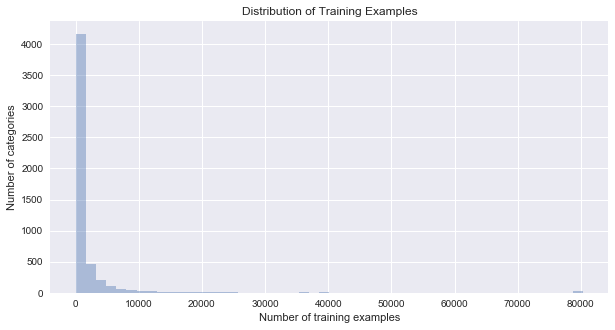

In [15]:
l = np.array(list(stats.values()))
b = l#[l>= 5000]
print(len(b), sum(b))
plt.figure(figsize=(10,5))
plt.ylabel('Number of categories')
plt.xlabel('Number of training examples')
plt.title('Distribution of Training Examples')
sns.distplot(b, kde=False)

## Methodology

### Transfer Learning
Due to the insufficiency of the training data (many classes have less than 100 examples), using it to train a randomly-initialized model will be very hard; convergence might take more than a couple of months with the limited hardware available.

Analysis of convolutional networks revealed that the filters near the bottom (i.e. at the input), have high activations on edges, lines, primitives, etc. And the higher the filters are in the network, the more they respond to more complex structures (e.g. whole face). In other words, the lower-level convolutional filters are more general-purpose than the higher-level ones.

In fact, the filters learned by CNNs are more general-purpose than initially thought. That is, a CNN originally trained for classification can also be used, with a little fine-tuning, in a segmentation task, for example.

In this project, transfer learning is used to bootstrap the training process instead of starting with random weights.

### Addressing the class imbalance
A couple of boosting methods were tried to address the class imbalance issue.

One is by using data augmentation to boost the number of training examples (if needed) to around 1,200 per class. For instance, if a class only has 100 examples, then each example will be augmented to produce 12 derivative images, which would result to 100 x 12 = 1,200 training images in total. The augmentation is done on-the-fly in order to generate infinitely many training examples while still being space efficient.

The other is by boosting the penalty or loss for misclassifications. This is implemented by multiplying the misclassification loss by a factor of 1200/N, where N is the number of training examples for that class. Doing so gives more 'weight' to classes with the lower number of training examples.

The boosting methods described above were applied separately.

### Faster training by caching CNN features
One epoch of training easily takes about 14 hours on a single GTX 1080 card, even with the layers of the base model being frozen. To drastically improve the training time, the whole training data is fed to the base Xception model, and the CNN features were cached into Numpy archives. This pretraining step enables us to rapidly train the classifier subnetwork by totally eliminating the CNN overhead during training. With this training optimization, one epoch takes just around 25 minutes.

